In [1]:
# Activate the library
import Pkg
Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/QuTaM.jl`


In [17]:
# Import all the necessary libraries
libraries = ["QuTaM", "LinearAlgebra", "Statistics", "Random", "QuadGK", "Plots", "LaTeXStrings", "OrdinaryDiffEq"]

function ensure_imports(packages::Vector{String})
    for pkg in packages
        try
            @eval using $(Symbol(pkg))
        catch e
            if e isa ArgumentError && occursin(pkg, e.msg)
                println("Installing $pkg...")
                Pkg.add(pkg)
                @eval using $(Symbol(pkg))
            else
                rethrow(e)
            end
        end
    end
end

ensure_imports(libraries)

Installing LaTeXStrings...


   Resolving package versions...
    Updating `~/Documents/Research/MonitoringMetrology/QuTaM.jl/Project.toml`
  [b964fa9f] + LaTeXStrings v1.4.0
    Updating `~/Documents/Research/MonitoringMetrology/QuTaM.jl/Manifest.toml`
 [b964fa9f] + LaTeXStrings v1.4.0


In [3]:
function rf_de!(dr, r, p, t)
    gamma = QuTaM.rf_gamma
    delta = QuTaM.rf_delta
    omega = QuTaM.rf_omega
    dr[1] = -0.5*gamma*r[1] - 2*delta*r[2]
    dr[2] = 2*delta*r[1] - 0.5*gamma*r[2] - 2*omega*r[3]
    dr[3] = 2*omega*r[2] - gamma*(r[3] + 1)
end

rf_de! (generic function with 1 method)

In [4]:
sys = QuTaM.rf_sys
params = QuTaM.rf_params

SimulParameters(psi0=ComplexF64[1.0 + 0.0im, 0.0 + 0.0im]
nsamples=75000
seed=1
ntraj=250)
multiplier=4.0
tf=25.0
dt=0.0013333333333333333
eps=0.001)

In [5]:
r0 = [0.0; 0.0; -1.0] # Initial Condition
tspan = (0.0, params.tf)
t_given = collect(LinRange(0, params.tf, 1000));

In [6]:
prob = ODEProblem(rf_de!, r0, tspan)
sol = solve(prob, reltol = 1e-6, saveat = t_given); 

In [7]:
# Steady State
gamma = QuTaM.rf_gamma
delta = QuTaM.rf_delta
omega = QuTaM.rf_omega
#r_steady = 1/(gamma^2 + 2*omega^2+4*delta^2) * [-4*delta*omega; 2*omega*gamma;-gamma^2-4*delta^2 ]

0.5

In [8]:
################## Average Simulation ################3
# Now from each trajectory, generate the states the given times
sample_clicks = QuTaM.run_trajectories(sys, params)
ntimes = size(t_given)[1]
sample = zeros(ComplexF64, ntimes, sys.NLEVELS, params.ntraj)
@time begin
    
for n in 1:params.ntraj
    states = QuTaM.evaluate_at_t(t_given, sample_clicks[n], sys,  params.psi0)
    for j in 1:sys.NLEVELS
        for tn in 1:ntimes
            sample[tn, j, n] = states[tn, j]
        end 
    end 
end

end 

  0.827985 seconds (4.92 M allocations: 446.187 MiB, 9.88% gc time, 2.38% compilation time)


In [9]:
# Obtain the observable on the sample.
r_sample = zeros(Float64, ntimes, 3, params.ntraj)
sigma = [QuTaM.sigma_x, QuTaM.sigma_y, QuTaM.sigma_z]

@time begin
for j in 1:params.ntraj
    for k in 1:3
        for tn in 1:ntimes
                r_sample[tn, k, j] = dot(sample[tn, :, j], sigma[k] * sample[tn, :, j])   # Drop the extra dimension
        end
    end
end 
end
# Average
r_avg = dropdims(mean(r_sample, dims=3), dims=3);

  0.902352 seconds (7.50 M allocations: 334.661 MiB, 7.01% gc time, 10.49% compilation time)


In [10]:
tau_sample = Vector{Float64}()
@time begin
for traj in sample_clicks
    if !isempty(traj)
        #    push!(tau_sample, traj[1].time)
        for click in traj
            push!(tau_sample, click.time)
        end 
    else
        continue
    end 
end 
end

  0.045167 seconds (9.47 k allocations: 379.242 KiB, 98.90% compilation time)


In [11]:
import HypothesisTests, Distributions
struct WTD_rf <: Distributions.ContinuousUnivariateDistribution
    omega::Float64
    gamma::Float64
    
end


function Distributions.support(d::WTD_rf)
    return Distributions.Interval(0, Inf)
end

function Distributions.pdf(d::WTD_rf, tau::Real)
        # Replace with your custom formula
        gamma = d.gamma
        omega = d.omega
        return (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    end

function Distributions.cdf(d::WTD_rf, t::Real)
    pdf(tau) = (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
    return quadgk(pdf, 0, t, rtol=1e-8)[1]
end 


function Base.rand(rng::AbstractRNG, d::WTD_rf)
    # Use inversion sampling
    alpha = rand() 
    t = 0
    dt = 0.001 # This is a magic number, the point is that this matches the dt in rf_params
    while Distributions.cdf(d, t) < alpha 
        t = dt + t
    end 
    return t  # Return a sample
end

In [12]:
f = WTD_rf(gamma, omega)

WTD_rf(omega=0.5, gamma=0.5)

In [13]:
f_sample = rand(f, 500);

In [14]:
HypothesisTests.ApproximateTwoSampleKSTest(tau_sample, f_sample)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.0364757

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.6908

Details:
    number of observations:   [1606,500]
    KS-statistic:              0.7122499306371768


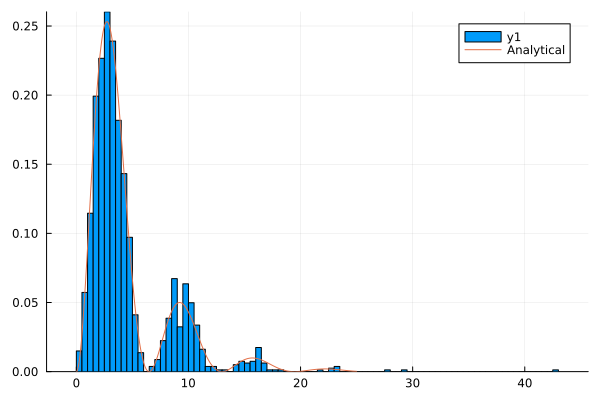

In [15]:
WTD_analytical(tau) =  (16*gamma*omega^2)*exp(-0.5*gamma*tau) * sin(0.25*tau*sqrt(16*omega^2-gamma^2))^2/(-gamma^2+16*omega^2)
histogram(tau_sample, normalize=:pdf)
plot!(t_given, Distributions.pdf.(f, t_given), label="Analytical")

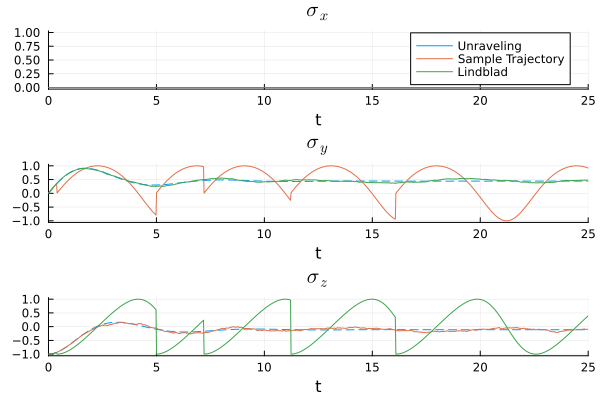

In [18]:
p1 = plot(t_given, r_avg[:, 1], label="Unraveling", title=L"\sigma_x")
plot!(t_given, r_sample[:,1, 1], label="Sample Trajectory")
plot!(sol, idxs =(0, 1), label="Lindblad ")
p2 = plot(sol, idxs =(0, 2), title=L"\sigma_y", line=:dash, legend=false)
plot!(t_given, r_sample[:,2, 1])
plot!(t_given, r_avg[:, 2])
p3 = plot(sol, idxs = (0,3), title=L"\sigma_z", line=:dash, legend=false)
plot!(t_given, r_avg[:, 3])
plot!(t_given, r_sample[:,3, 1])
plot(p1, p2,p3,  layout=(3, 1))